In [1]:
import os
import json
from collections import defaultdict
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dateutil.parser import parse
import itertools
import datetime
import time
import torch
import random
import ast

In [2]:
dataset_path = '/home/omnious/workspace/yeskendir/Influencer_Export_autotagged/'
oms_dataset = os.path.join(dataset_path, "influencer_json")
example_file = os.path.join(oms_dataset, "6a0c0125-2e0a-11ea-90d5-02607f665cd2.json")
nonempty_oms_dataset = os.path.join(dataset_path, "nonempty_influencer_json")

### Convert upload time to week

In [3]:
# Option 1: date -> week [0, 71]

def date2week(upload_date):
    # e.g. upload_date =  "2020-11-14 10:27:43"
    ymd = upload_date.split()[0]
    date_series = pd.Series([ymd])
    date_series = date_series.map(lambda x: parse(x))
    [week_no] = date_series.dt.isocalendar().week.tolist()
    last_week_2019 = 20191229  #"2019-12-29" # 52
    last_week_2020 = 20210103 #"2021-01-03" # 53
    [year, month, day] = ymd.split("-")
    ymd = int(year+month+day)
    # print("relative week", week_no)
    if ymd > last_week_2019 and ymd < last_week_2020:
        week_no += 52
    elif ymd > last_week_2020:
        week_no += 52 + 53
    week_no -= 44
    return week_no


def format_week(w):
    if w <= 8:
        return w + 44
    elif w <= 61:
        return w - 8
    else:
        return w - 61


upload_date = "2021-03-23 10:27:43"
upload_date = "2019-12-30 22:01:19"
#upload_date = "2019-11-19 22:01:19"

#upload_date = "2020-12-28 22:01:19"
#upload_date = "2019-11-03 18:33:22" # earliest date
#upload_date = "2021-06-22 04:30:32" # latest week
week_no = date2week(upload_date)
print("date: ", upload_date, "week_no: ", week_no, format_week(week_no))

date:  2019-12-30 22:01:19 week_no:  9 1


### Build dataset

In [4]:

# Merge some groups: location: local, global, all (location + global)
#                    target age: 10, 20, 30 40, >50, 10_20, 20_30, 30_40
#                    segment: nano, micro, macro, mega, nano_micro
# Merge some influencer groups (above) if MERGE is True
MERGE = True
N = 88

candidate_attributes = ['item', 'color', 'length', 'fit', 'shape', 'neckline', 'collar', 
                        'look', 'gender', 'sleeve_length', 'sleeve_shape', 'design_detail', 'material', 'print']

all_data = {}

for file in tqdm(glob.glob(os.path.join(nonempty_oms_dataset, '*.json'))):
    with open(file) as json_file:
        data = json.load(json_file)
        posts = data["posts"]
        
        # Create influencer groups
        #locations = []
        locations = ["location:" + x["name"] for x in data["location"]]
        # merge locations
        if MERGE:
            locations.append("location:All")
        segments = []
        segments = ["segment:" + x["name"].split()[0].strip() for x in data["segment"]]
        # merge segments
        if MERGE:
            merged_segments = []
            if "segment:Nano" in segments or "segment:Micro" in segments:
                merged_segments.append("segment:Nano_AND_Micro")
            merged_segments.append("segment:All")
            segments.extend(merged_segments)
        
        target_ages = []
        
        for age in data["target_age"]:
            target_ages.append("target_age:" + age["name"].split("''")[0].strip())
        
        # merge target_ages
        if MERGE:
            merged_target_ages = []
            if "target_age:10's" in target_ages or "target_age:20's" in target_ages:
                merged_target_ages.append("target_age:10's_AND_20's")
            if "target_age:30's" in target_ages or "target_age:20's" in target_ages:
                merged_target_ages.append("target_age:20's_AND_30's")
            if "target_age:30's" in target_ages or "target_age:40's" in target_ages:
                merged_target_ages.append("target_age:30's_AND_40's")
            merged_target_ages.append("target_age:All")
            target_ages.extend(merged_target_ages)
        
        
        forPermutation = [locations, segments, target_ages]
        allPermutations = list(itertools.product(*forPermutation))
        currInfluencerGroups = []
        for p in allPermutations:
            influencer_group_name = "__".join(p)
            currInfluencerGroups.append(influencer_group_name)
        
        for post in posts:
            upload_date = post["upload_date"]
            week_no = date2week(upload_date)
            thisPostFashionElements = []
            for bbox in post["bbox"]:
                for attribute in candidate_attributes:
                    if not bbox[attribute]:
                        continue
                    
                    uniques_elements = [ast.literal_eval(el1) for el1 in set([str(el2) for el2 in bbox[attribute]])]
                    for element in uniques_elements:
                        if not element["name"]:
                            continue
                        fashion_element = ":".join([attribute, element["name"]])
                        thisPostFashionElements.append(fashion_element)
            influencerFashionElementPairs = [currInfluencerGroups, thisPostFashionElements]
            influencerFashionElementPairs = list(itertools.product(*influencerFashionElementPairs))
            
            for (IG, FE) in influencerFashionElementPairs:
                if IG not in all_data.keys():
                    # all_data[IG] = {FE: [[week_no, 1]]}
                    all_data[IG] = {FE: [[x, 0] for x in range(N)]}
                    all_data[IG][FE][week_no][1] += 1
                elif FE not in all_data[IG].keys():
                    # all_data[IG][FE] = [[week_no, 1]]
                    all_data[IG][FE] = [[x, 0] for x in range(N)]
                    all_data[IG][FE][week_no][1] += 1
                else:
                    all_data[IG][FE][week_no][1] += 1



100%|██████████| 8433/8433 [1:06:27<00:00,  2.11it/s]


In [6]:
len(all_data.keys())

162

In [4]:

# Merge some groups: location: local, global, all (location + global)
#                    target age: 10, 20, 30 40, >50, 10_20, 20_30, 30_40
#                    segment: nano, micro, macro, mega, nano_micro
# Merge some influencer groups (above) if MERGE is True

# Build with only one user group

'''
N = 88

candidate_attributes = ['item', 'color', 'length', 'fit', 'shape', 'neckline', 'collar', 
                        'look', 'gender', 'sleeve_length', 'sleeve_shape', 'design_detail', 'material', 'print']

all_data = {}

for file in tqdm(glob.glob(os.path.join(nonempty_oms_dataset, '*.json'))):
    with open(file) as json_file:
        data = json.load(json_file)
        posts = data["posts"]
        
        currInfluencerGroups = ["location:All__segment:All__target_age:All"]
        
        for post in posts:
            upload_date = post["upload_date"]
            week_no = date2week(upload_date)
            thisPostFashionElements = []
            for bbox in post["bbox"]:
                for attribute in candidate_attributes:
                    if not bbox[attribute]:
                        continue
                    
                    uniques_elements = [ast.literal_eval(el1) for el1 in set([str(el2) for el2 in bbox[attribute]])]
                    for element in uniques_elements:
                        if not element["name"]:
                            continue
                        fashion_element = ":".join([attribute, element["name"]])
                        thisPostFashionElements.append(fashion_element)
            influencerFashionElementPairs = [currInfluencerGroups, thisPostFashionElements]
            influencerFashionElementPairs = list(itertools.product(*influencerFashionElementPairs))
            
            for (IG, FE) in influencerFashionElementPairs:
                if IG not in all_data.keys():
                    # all_data[IG] = {FE: [[week_no, 1]]}
                    all_data[IG] = {FE: [[x, 0] for x in range(N)]}
                    all_data[IG][FE][week_no][1] += 1
                elif FE not in all_data[IG].keys():
                    # all_data[IG][FE] = [[week_no, 1]]
                    all_data[IG][FE] = [[x, 0] for x in range(N)]
                    all_data[IG][FE][week_no][1] += 1
                else:
                    all_data[IG][FE][week_no][1] += 1

'''


100%|██████████| 8433/8433 [56:53<00:00,  2.47it/s]   


In [5]:
# remove data with sparsity >= 50%

removed = 0
total = 0

for influencer in tqdm(list(all_data.keys())):
    for fashion in list(all_data[influencer].keys()):
        zeros = 0
        for i in range(len(all_data[influencer][fashion])):
            if all_data[influencer][fashion][i][1] == 0:
                zeros += 1
        
        zeros = 100 * zeros / 88
        if zeros >= 50:
            del all_data[influencer][fashion]
            removed += 1
        total += 1

print(100 * removed / total)


100%|██████████| 1/1 [00:00<00:00, 134.64it/s]

0.0


In [6]:
# format weeks from [0, ..., 87] to [47, ..., 52,1,..., 53,..]
for influencer in tqdm(list(all_data.keys())):
    for fashion in list(all_data[influencer].keys()):
        for i in range(len(all_data[influencer][fashion])):
            all_data[influencer][fashion][i][0] = format_week(all_data[influencer][fashion][i][0])

100%|██████████| 1/1 [00:00<00:00, 54.52it/s]


In [7]:
#Rank fashion data

Tmax = 88
'''
for influencer in tqdm(list(all_data.keys())):
    for t in range(Tmax+1):
        Nt = 0
        for fashion in list(all_data[influencer].keys()):
            if t < len(all_data[influencer][fashion]):
                Nt += list(all_data[influencer][fashion][t])[1]
        if Nt == 0:
            continue
        for fashion in list(all_data[influencer].keys()):
            if t < len(all_data[influencer][fashion]):
                 all_data[influencer][fashion][t][1] /= float(Nt)

'''

# NEW RANKING


for influencer in tqdm(list(all_data.keys())):
    for t in range(Tmax+1):
        Nt = defaultdict(int)
        for fashion in list(all_data[influencer].keys()):
            category_name = fashion.split(":")[0]
            if t < len(all_data[influencer][fashion]):
                Nt[category_name] += list(all_data[influencer][fashion][t])[1]
            
        for fashion in list(all_data[influencer].keys()):
            category_name = fashion.split(":")[0]
            if Nt[category_name] == 0:
                continue
            if t < len(all_data[influencer][fashion]):
                all_data[influencer][fashion][t][1] /= float(Nt[category_name])


100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


In [34]:
#all_data['location:All__segment:All__target_age:All']['color:Navy']

100%|██████████| 1/1 [00:00<00:00, 75.60it/s]


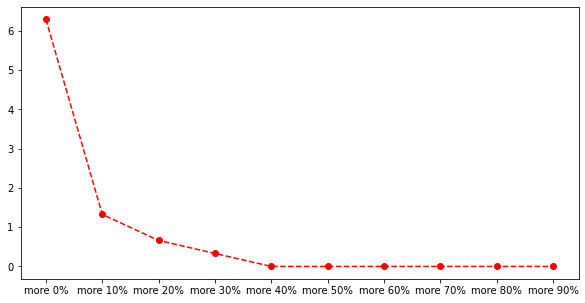

[6.291390728476821, 1.3245033112582782, 0.6622516556291391, 0.33112582781456956, 0, 0, 0, 0, 0, 0]


In [8]:
## Count sparsity 
from collections import defaultdict
sparsity = defaultdict(int)
total = 0
for influencer in tqdm(list(all_data.keys())):
    for fashion in list(all_data[influencer].keys()):
        zeros = 0
        assert len(all_data[influencer][fashion]) == 88
        for i in range(len(all_data[influencer][fashion])):
            if all_data[influencer][fashion][i][1] == 0:
                zeros += 1
        zeros = 100 * zeros / 71
        if zeros >= 90:
            sparsity["more 90%"] += 1
        if zeros >= 80:
            sparsity["more 80%"] += 1
        if zeros >= 70:
            sparsity["more 70%"] += 1
        if zeros >= 60:
            sparsity["more 60%"] += 1
        if zeros >= 50:
            sparsity["more 50%"] += 1
        if zeros >= 40:
            sparsity["more 40%"] += 1
        if zeros >= 30:
            sparsity["more 30%"] += 1
        if zeros >= 20:
            sparsity["more 20%"] += 1
        if zeros >= 10:
            sparsity["more 10%"] += 1
        if zeros > 0:
            sparsity["more 0%"] += 1
        #if zeros == 0:
        #    sparsity["0%"] += 1
        #sparsity[1 + zeros//10] += 1
        total += 1
for k in sparsity.keys():
    sparsity[k] = 100 * sparsity[k] / total

x_axis = ['more 0%', 'more 10%', 'more 20%', 'more 30%', 'more 40%', 'more 50%', 'more 60%', 'more 70%', 'more 80%', 'more 90%']
y_axis = []
for x in x_axis:
    y_axis.append(sparsity[x])

plt.figure(figsize=(10,5))
plt.plot(x_axis, y_axis, 'ro', linestyle='dashed')
plt.show()
print(y_axis)

In [9]:
# Normalize

norm_all_data = {}
norm_data_stat = {}
eps = 0.01
#eps = 0.0

for influencer in tqdm(list(all_data.keys())):
    for fashion in list(all_data[influencer].keys()):
        week_num = all_data[influencer][fashion]
        timeline = [int(x[0]) for x in week_num]
        trend = [x[1] for x in week_num]
        if len(trend) == 0 or len(timeline) == 0:
            print("empty 1: ", influencer, fashion, len(trend), len(timeline))
            continue
        
        max_v = max(trend)
        min_v = min(trend)
        normed_trend = [max((x-min_v)/(max_v-min_v + 1e-20), eps) for x in trend]
        res = []
        for time_s, trend_v in zip(timeline, normed_trend):
            res.append([time_s, trend_v])
        
        if len(res) == 0:
            print("empty 2: ", influencer, fashion, len(res))
        
        if influencer not in norm_all_data.keys():
            norm_all_data[influencer] = {fashion: res}
            norm_data_stat[influencer] = {fashion: [min_v, max_v, eps]}
        else:
            norm_all_data[influencer][fashion] = res
            norm_data_stat[influencer][fashion] = [min_v, max_v, eps]
        

100%|██████████| 1/1 [00:00<00:00, 26.55it/s]


In [11]:
#norm_all_data['location:All__segment:All__target_age:All']['color:Navy']

In [10]:
# Save files

filename = dataset_path + "12072021_auto_All_data.json"
filename_norm = dataset_path + "12072021_auto_All_data_norm.json"
print(filename)
print(filename_norm)

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)
save = True
if save:
    with open(filename, "w") as outfile:
        json.dump(norm_all_data, outfile, cls=NpEncoder)

    with open(filename_norm, "w") as outfile_norm:
        json.dump(norm_data_stat, outfile_norm, cls=NpEncoder)
    print("SAVED")
else:
    print("NOT SAVED")

/home/omnious/workspace/yeskendir/Influencer_Export_autotagged/12072021_auto_All_data.json
/home/omnious/workspace/yeskendir/Influencer_Export_autotagged/12072021_auto_All_data_norm.json
SAVED


### For distance map 

In [4]:
N = 88 # for Option 1 date2week
candidate_attributes = ['item', 'color', 'length', 'fit', 'shape', 'neckline', 'collar', 
                        'look', 'gender', 'sleeve_length', 'sleeve_shape', 'design_detail', 'material', 'print']
fashion_data = {}

for file in tqdm(glob.glob(os.path.join(nonempty_oms_dataset, '*.json'))):
    with open(file) as json_file:
        data = json.load(json_file)
        posts = data["posts"]

        
        for post in posts:
            upload_date = post["upload_date"]
            week_no = date2week(upload_date)
            thisPostFashionElements = []
            for bbox in post["bbox"]:
                for attribute in candidate_attributes:
                    if not bbox[attribute]:
                        continue
                    uniques_elements = [ast.literal_eval(el1) for el1 in set([str(el2) for el2 in bbox[attribute]])]
                    for element in uniques_elements:
#                     for element in bbox[attribute]:
                        if not element["name"]:
                            continue
#                         if attribute == "item":
#                             fashion_element = ":".join([attribute, element["category_name"], element["name"]])
#                         else:
                        fashion_element = ":".join([attribute, element["name"]])
                        thisPostFashionElements.append(fashion_element)
            
            for FE in thisPostFashionElements:
                if FE not in fashion_data.keys():
                    fashion_data[FE] = [[x, 0] for x in range(N)]
                    fashion_data[FE][week_no][1] += 1
                else: 
                    fashion_data[FE][week_no][1] += 1
            



100%|██████████| 8433/8433 [56:34<00:00,  2.48it/s]  


In [5]:
# Rank fashion data

# NEW RANKING
Tmax = 88
for t in range(Tmax+1):
    Nt = defaultdict(int)
    for fashion in list(fashion_data.keys()):
        category_name = fashion.split(":")[0]
        if t < len(fashion_data[fashion]):
            Nt[category_name] += list(fashion_data[fashion][t])[1]

    for fashion in list(fashion_data.keys()):
        category_name = fashion.split(":")[0]
        if Nt[category_name] == 0:
            continue
        if t < len(fashion_data[fashion]):
            fashion_data[fashion][t][1] /= float(Nt[category_name])

In [6]:
# Normalize fashion data

norm_fashion_data = {}
norm_fashion_stat = {}
eps = 0.01
#eps = 0.0

for fashion in list(fashion_data.keys()):
    week_num = fashion_data[fashion]
    timeline = [int(x[0]) for x in week_num]
    trend = [x[1] for x in week_num]
    if len(trend) == 0 or len(timeline) == 0:
        print("empty 1: ", fashion, len(trend), len(timeline))
        continue

    max_v = max(trend)
    min_v = min(trend)
    normed_trend = [max((x-min_v)/(max_v-min_v + 1e-20), eps) for x in trend]
    res = []
    for time_s, trend_v in zip(timeline, normed_trend):
        res.append([time_s, trend_v])

    if len(res) == 0:
        print("empty 2: ", influencer, fashion, len(res))

    if fashion not in norm_fashion_data.keys():
        norm_fashion_data[fashion] = res
        norm_fashion_stat[fashion] = [min_v, max_v, eps]
    else:
        norm_fashion_data[fashion] = res
        norm_fashion_stat[fashion] = [min_v, max_v, eps]

In [7]:
filename = dataset_path + "01072021_auto_fashion_data.json"
filename_norm = dataset_path + "01072021_auto_fashion_data_norm.json"
print(filename)
print(filename_norm)

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

with open(filename, "w") as outfile:
    json.dump(norm_fashion_data, outfile, cls=NpEncoder)

with open(filename_norm, "w") as outfile_norm:
    json.dump(norm_fashion_stat, outfile_norm, cls=NpEncoder)

/home/omnious/workspace/yeskendir/Influencer_Export_autotagged/01072021_auto_fashion_data.json
/home/omnious/workspace/yeskendir/Influencer_Export_autotagged/01072021_auto_fashion_data_norm.json
